In [1]:
import pandas as pd
import numpy as np

In [2]:
file_path = r'C:\Users\user\Downloads\WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [3]:
df_churn = pd.read_csv(file_path)
print("Dataset Loaded Successfully using full path.")
print("--- First 5 Rows ---")
print(df_churn.head())
print("\n--- Data Information ---")
print(df_churn.info())

Dataset Loaded Successfully using full path.
--- First 5 Rows ---
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
sns.set_style("whitegrid")

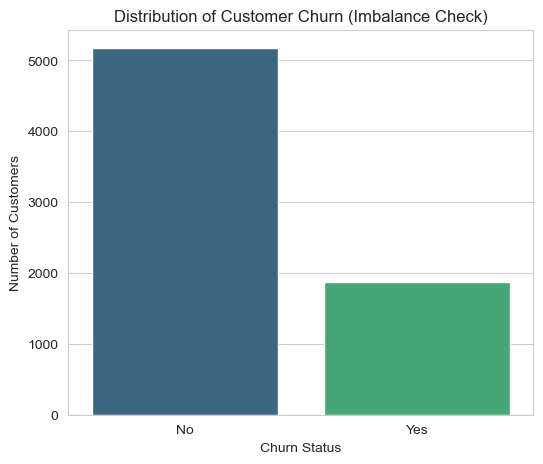

In [6]:
plt.figure(figsize=(6, 5))
sns.countplot(x='Churn', data=df_churn, palette='viridis')
plt.title('Distribution of Customer Churn (Imbalance Check)')
plt.ylabel('Number of Customers')
plt.xlabel('Churn Status')
plt.savefig('churn_imbalance.png')

In [7]:
plt.show()

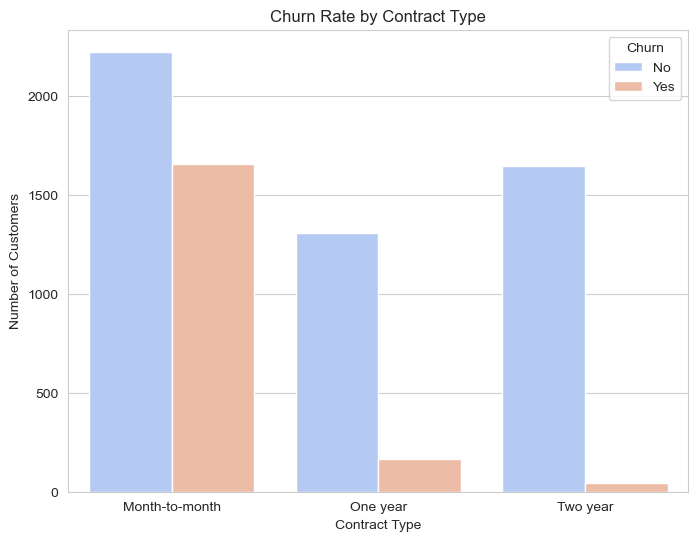

In [8]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Contract', hue='Churn', data=df_churn, palette='coolwarm')
plt.title('Churn Rate by Contract Type')
plt.ylabel('Number of Customers')
plt.xlabel('Contract Type')
plt.savefig('churn_by_contract.png')

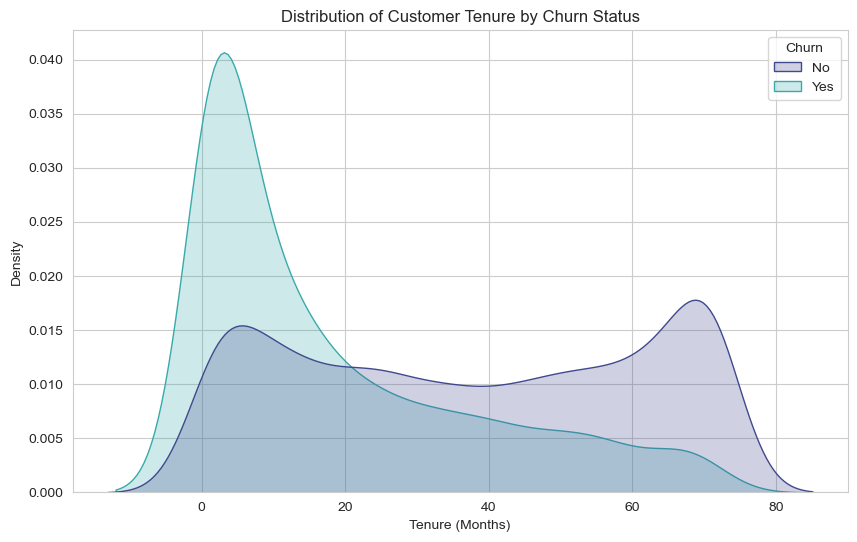

In [9]:
# 1. Churn Rate by Tenure (Time is Money)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_churn, x='tenure', hue='Churn', fill=True, common_norm=False, palette='mako')
plt.title('Distribution of Customer Tenure by Churn Status')
plt.xlabel('Tenure (Months)')
plt.ylabel('Density')
plt.savefig('churn_by_tenure_kde.png')

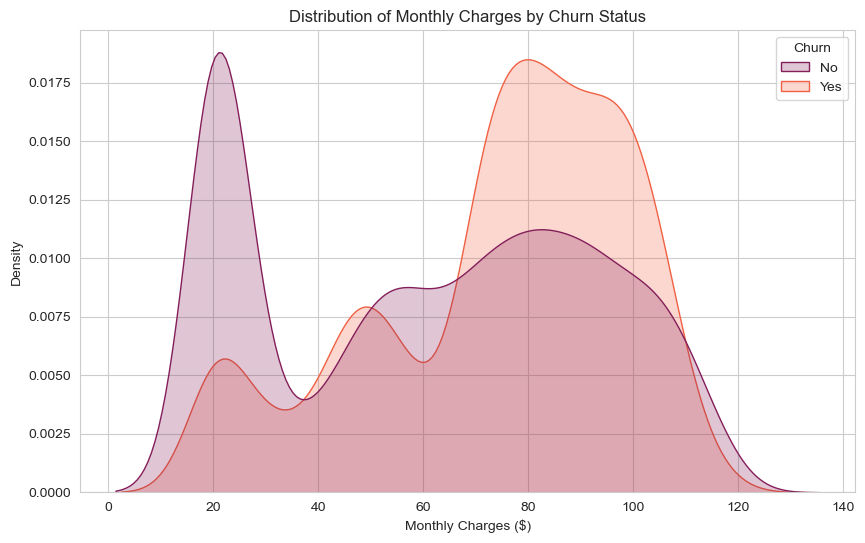

In [10]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_churn, x='MonthlyCharges', hue='Churn', fill=True, common_norm=False, palette='rocket')
plt.title('Distribution of Monthly Charges by Churn Status')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Density')
plt.savefig('churn_by_monthly_charges_kde.png')

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

In [12]:
# --- 1. Handling Missing Values and Data Type Conversion ---

# TotalCharges is often read as object due to a few customers with 0 tenure (new customers).
# 'errors='coerce' turns non-numeric values into NaN.
df_churn['TotalCharges'] = pd.to_numeric(df_churn['TotalCharges'], errors='coerce')

In [13]:
# Fill resulting NaNs (which correspond to tenure=0 customers) with 0.
df_churn['TotalCharges'].fillna(0, inplace=True)

In [14]:
# Drop the customerID column as it is not necessary for prediction
df_churn.drop('customerID', axis=1, inplace=True)

In [15]:
# Target variable 'Churn' and other 'Yes'/'No'/'Male'/'Female' columns are binary (2 categories).
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

In [16]:
# Identify all other binary object columns and add them to the list
for col in df_churn.columns:
    if df_churn[col].dtype == 'object' and df_churn[col].nunique() == 2:
        binary_cols.append(col)

In [17]:
# Convert all binary columns to 0/1 using LabelEncoder
le = LabelEncoder()
for col in binary_cols:
    if col == 'Gender': # Gender has Male/Female, others are Yes/No
        df_churn[col] = le.fit_transform(df_churn[col].replace({'Female': 0, 'Male': 1}))
    else:
        df_churn[col] = le.fit_transform(df_churn[col])

In [18]:
# Identify columns that are still objects and have more than 2 unique values
multi_category_cols = [col for col in df_churn.columns if df_churn[col].dtype == 'object' and df_churn[col].nunique() > 2]

In [19]:
df_churn = pd.get_dummies(df_churn, columns=multi_category_cols, drop_first=True)

In [20]:
# --- 4. Separate Features (X) and Target (y) ---
X = df_churn.drop('Churn', axis=1)
y = df_churn['Churn'] # Churn is now 0 (No) or 1 (Yes)

In [21]:
# --- 5. Scaling Numerical Features (MinMax Scaling) ---
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = MinMaxScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

In [22]:
print("Data Preprocessing Complete!")
print("----------------------------")
print(f"Final Features Shape (X): {X.shape}")
print(f"The number of features increased due to One-Hot Encoding.")
print(f"Final Features Columns (X head):")
print(X.head())
print(f"\nTarget Variable Summary (y):")
print(y.value_counts())

Data Preprocessing Complete!
----------------------------
Final Features Shape (X): (7043, 30)
The number of features increased due to One-Hot Encoding.
Final Features Columns (X head):
   gender  SeniorCitizen  Partner  Dependents    tenure  PhoneService  \
0       0              0        1           0  0.013889             0   
1       1              0        0           0  0.472222             1   
2       1              0        0           0  0.027778             1   
3       1              0        0           0  0.625000             0   
4       0              0        0           0  0.027778             1   

   PaperlessBilling  MonthlyCharges  TotalCharges  \
0                 1        0.115423      0.003437   
1                 0        0.385075      0.217564   
2                 1        0.354229      0.012453   
3                 0        0.239303      0.211951   
4                 1        0.521891      0.017462   

   MultipleLines_No phone service  ...  TechSupport_Yes 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

ModuleNotFoundError: No module named 'xgboost'

In [24]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/30/7d/41847e45ff075f3636c95d1000e0b75189aed4f1ae18c36812575bb42b4b/xgboost-3.1.2-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB 330.3 kB/s eta 0:03:38
   ---------------------------------------- 0.0/72.0 MB 330.3 kB/s eta 0:03:38
   ---------------------------------------- 0.0/72.0 MB 330.3 kB/s eta 0:03:38
   ---------------------------------------- 0.0/72.0 MB 330.3 kB/s eta 0:03:38
   ---------------------------------------- 0.1/72.0 MB 234.9 kB/s eta 0:05:07
   ---------------------------------------- 0.1/72.0 MB 309.1 kB/s eta 0:03:53
   ---------------------------------------- 0.1/72.0 MB 328.0 kB/s eta 0:03:40
   ---------------------------------------- 0.1/72.0 MB 328.0 kB/s eta 0:03:40
   ---------------------------------------- 0.2/72.0 MB 353.1 kB/s eta 0:03:24
   -----------

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

In [26]:
# --- 1. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data split complete.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Data split complete.
Training set shape: (5634, 30)
Testing set shape: (1409, 30)


In [27]:
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42),
    "XGBoost Classifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [28]:
# --- 3. Train and Evaluate ---
print("\n--- Model Training and Evaluation ---")
print(f"{'Model':<25} | {'Accuracy':<10} | {'AUC-ROC':<10} | {'F1-Score':<10}")
print("-" * 65)

best_model = None
best_auc = -1


--- Model Training and Evaluation ---
Model                     | Accuracy   | AUC-ROC    | F1-Score  
-----------------------------------------------------------------


In [29]:
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:18:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [30]:
# --- 3. Train and Evaluate ---
print("\n--- Model Training and Evaluation ---")
print(f"{'Model':<25} | {'Accuracy':<10} | {'AUC-ROC':<10} | {'F1-Score':<10}")
print("-" * 65)

best_model = None
best_auc = -1

for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)


--- Model Training and Evaluation ---
Model                     | Accuracy   | AUC-ROC    | F1-Score  
-----------------------------------------------------------------


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [09:18:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [32]:
# Predict probabilities (needed for AUC-ROC) and classes (needed for Accuracy/F1)
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

In [34]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred_proba)
f1 = f1_score(y_test, y_pred)

print(f"{name:<25} | {accuracy:<10.4f} | {auc_roc:<10.4f} | {f1:<10.4f}")

XGBoost Classifier        | 0.7722     | 0.8224     | 0.5368    


In [38]:
# Track the best model based on AUC-ROC
if auc_roc > best_auc:
    best_auc = auc_roc
    best_model = model

In [39]:
best_model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [40]:
model

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [41]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [43]:
feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

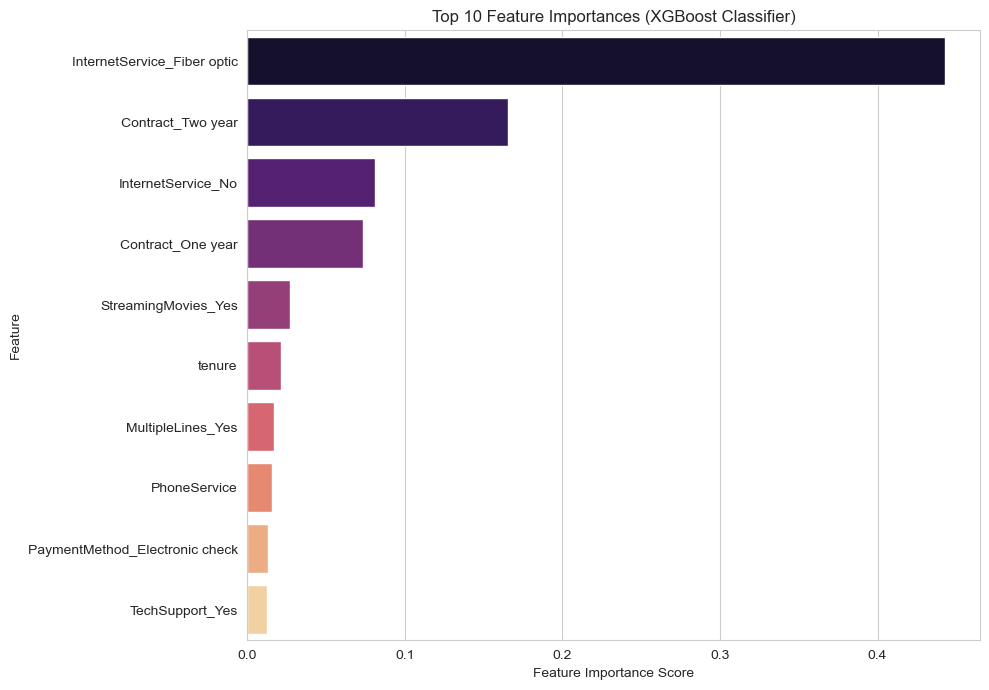

In [44]:
plt.figure(figsize=(10, 7))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='magma')
plt.title('Top 10 Feature Importances (XGBoost Classifier)')
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png')

In [45]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

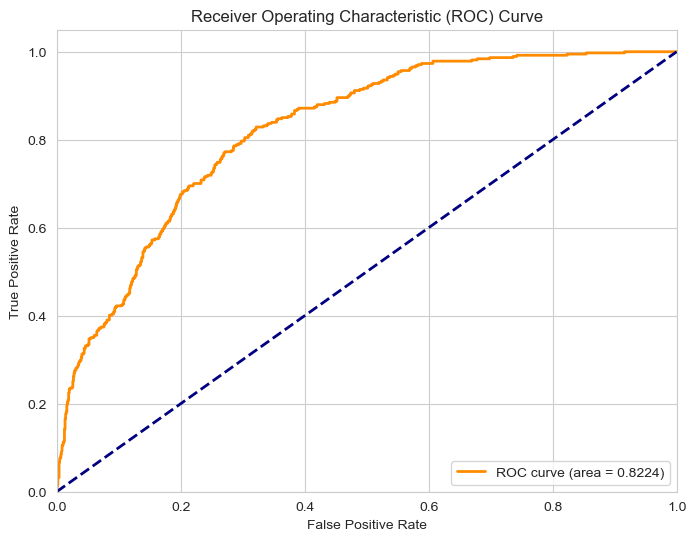

In [46]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('xgb_roc_curve.png')